In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

## Load data

Data are available at https://www.kaggle.com/c/ashrae-energy-prediction/data

In [2]:
building = pd.read_csv('building_metadata.csv')
train = pd.read_csv('train.csv')
weather = pd.read_csv('weather_train.csv')

#train = train[train["building_id"].isin(building.building_id.values)]
train['timestamp'] = pd.to_datetime(train['timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

train_building = train.join(building.set_index(["building_id"]), on=["building_id"])
all_joined = train_building.join(weather.set_index(["site_id", "timestamp"]), on=["site_id", "timestamp"])

In [3]:
building.head(1)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN


In [4]:
train.head(1)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0


In [5]:
train['timestamp'][1]

Timestamp('2016-01-01 00:00:00')

In [6]:
weather.head(1)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


## Class for olap cubes

In [7]:
class Olap:
    def __init__(self):
        pass
    
    def create(self, dfs, interest, dim_names):
        # create OLAP cube from DataFrame
        self.dfs = dfs
        self.interest = interest
        self.dim = dim_names
        
        list_of_dim_values = [None] * len(self.dim)
        shape_of_cube = [None] * len(self.dim)
        
        df = self.dfs
        for i, dim in enumerate(self.dim):
            array = np.array(list(set(df[dim].values)))
            array.sort()
            list_of_dim_values[i] = array
            shape_of_cube[i] = len(list_of_dim_values[i])            

        cube = np.full(shape_of_cube, None)

        df = df.set_index(self.dim)
        #print(df)
        j = 0
        for idx, value in np.ndenumerate(cube):
            #print(idx, value)
            
            values_for_pd = [None] * len(self.dim) 
            for i, dim in enumerate(self.dim):
                values_for_pd[i] = list_of_dim_values[i][idx[i]]
            try:
                cube[idx] = df.loc[tuple(values_for_pd)][self.interest]
                #print(cube.shape)
                j+=1
                if j%10000==0:
                    #print(j)
                    pass
            except:
                pass
            
        self.cube = cube
        self.dim_values = list_of_dim_values

    def save(self, name='cube', file='Cubes'):
        # save cube
        dim_names = copy.deepcopy(self.dim)
        dim_names.append(self.interest)
        
        print(dim_names)
        
        np.save(file + '/' + name + '_cube.npy' , self.cube)
        np.save(file + '/' + name + '_dim_values.npy' , self.dim_values)
        np.save(file + '/' + name + '_names.npy' , dim_names)
        
    def load(self, name='cube', file='Cubes'):
        # load saved cube
        self.cube = np.load(file + '/' + name + '_cube.npy', allow_pickle=True)
        self.dim_values = np.load(file + '/' + name + '_dim_values.npy', allow_pickle=True)
        dim_names = np.load(file + '/' + name + '_names.npy', allow_pickle=True)
        
        self.dim = list(dim_names[0:-1])
        self.interest = str(dim_names[-1])
        
        print(self.dim)
        pass
    
    def returnCube(self):
        # return the cube in array form
        return self.cube, self.dim_values, self.dim, self.interest
    
    def linePlot(self, features_values, ranges = [None, None]):
        # create plots
        features = list(features_values.keys())
        x_ax = None
        observe = None
            
        indexing = [-1] * len(self.dim)
        for j, dim in enumerate(self.dim):
            if dim in features:
                indexing[j] = list(self.dim_values[j]).index(features_values[dim])
            else:
                observe = dim
                x_ax = self.dim_values[j]
                indexing[j] = slice(0, None, 1)
        
        indexing = tuple(indexing)
        data = self.cube[indexing]
        
        plt.title(self.interest + '(' + observe + ')')
        if ranges[0] == None:
            plt.plot(x_ax, data)
        else:
            start = np.where(x_ax > ranges[0])
            end = np.where(x_ax > ranges[1])
            plt.plot(x_ax[start[0][0]:end[0][0]], data[start[0][0]:end[0][0]])
        plt.show()
        pass

## Create cubes and plot data

### Cube for meter reading

Create cube only for few bulildings oterwise it takes too much time.

In [8]:
olap = Olap()
olap.create(train[train.building_id < 10], 'meter_reading', ['building_id', 'timestamp', 'meter'])
olap.save()

['building_id', 'timestamp', 'meter', 'meter_reading']


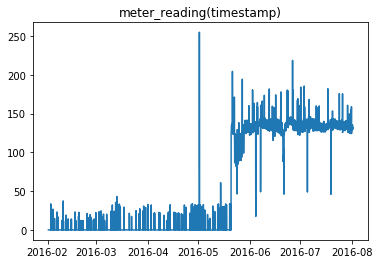

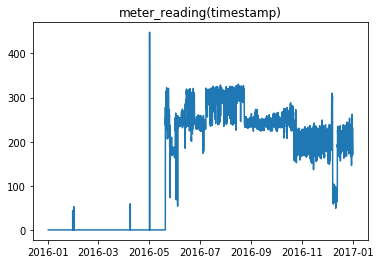

In [9]:
olap.linePlot({'building_id':1, 'meter':0}, [np.datetime64(pd.Timestamp(2016, 2, 1, 12)), np.datetime64(pd.Timestamp(2016, 8, 1, 12))])
olap.linePlot({'building_id':0, 'meter':0}, )

### Cubes for wetaher features

In [10]:
olap2 = Olap()
olap2.create(weather, 'cloud_coverage', ['site_id', 'timestamp'])
olap2.save(name='weather_cube')

['site_id', 'timestamp', 'cloud_coverage']


In [11]:
olap3 = Olap()
olap3.create(weather, 'sea_level_pressure', ['site_id', 'timestamp'])
olap3.save(name='weather_cube')

['site_id', 'timestamp', 'sea_level_pressure']


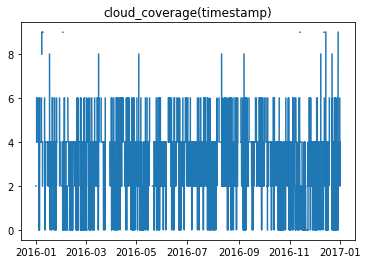

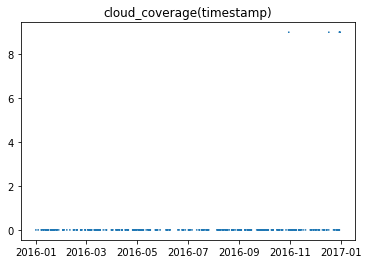

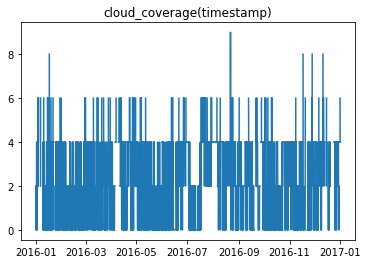

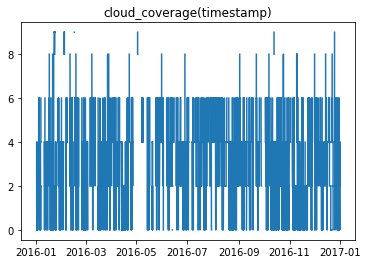

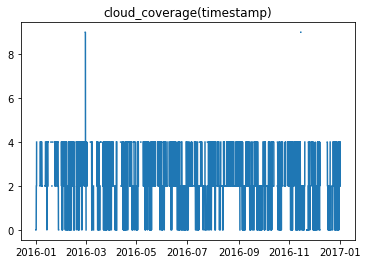

In [21]:
for i in range(5):
    olap2.linePlot({'site_id':i})

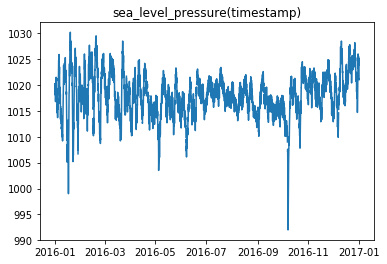

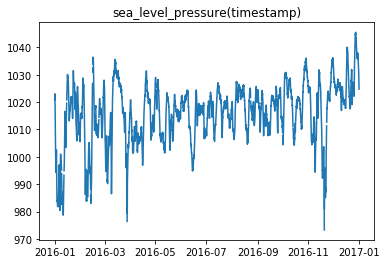

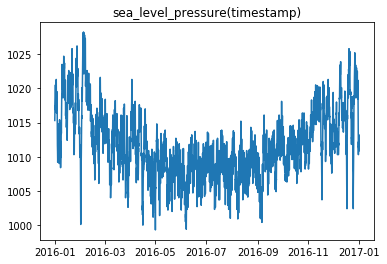

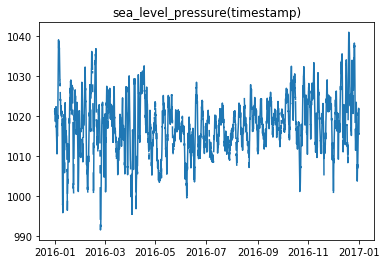

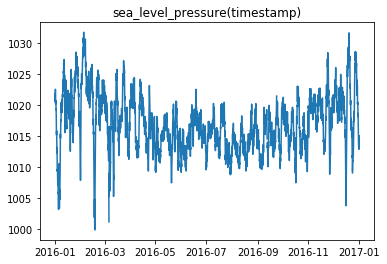

In [20]:
for i in range(5):
    olap3.linePlot({'site_id':i})

## Olap for temperature in each building

In [14]:
olap4 = Olap()
olap4.create(all_joined[all_joined.building_id < 10], 'air_temperature', ['building_id', 'timestamp'])

C:\Users\Matej\.conda\envs\percep\lib\site-packages\ipykernel_launcher.py:32: PerformanceWarning: indexing past lexsort depth may impact performance.


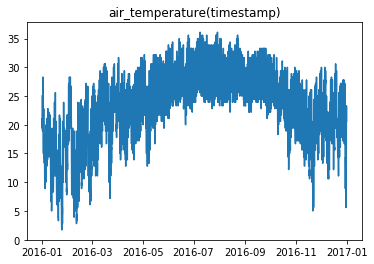

In [15]:
olap4.linePlot({'building_id':0})

In [ ]:
olap4.linePlot({'building_id':2})

## Use cube manualy

In [16]:
cube, features_values, feature_names, name = olap3.returnCube()

In [17]:
cube.shape

(16, 8784)

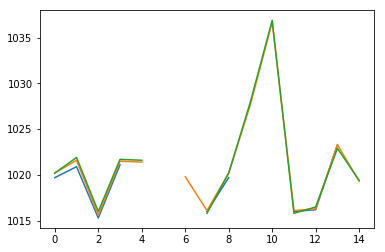

In [18]:
plt.plot(cube[0:,0:3])

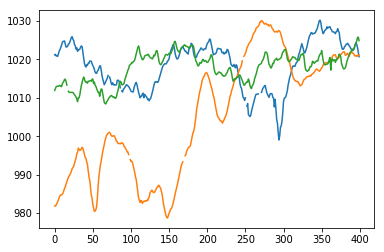

In [19]:
plt.plot(cube[0:3,100:500].transpose())